In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/TestModel/'

/content/drive/MyDrive/TestModel


In [ ]:
# import here
import os
import PIL
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.utils.data.sampler as sampler
from torch import nn, optim
import torch.nn.functional as F
%matplotlib inline

---
# Load The Data

In [ ]:
# Load pickled data
training_file = "data/train.p"
validation_file = "data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

# Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [ ]:
# Number of training examples
n_train = len(X_train)
# Number of validation examples.
n_valid = len(X_valid)
# Number of testing examples.
n_test = len(X_test)

# The shape of an traffic sign image
image_shape = X_train[0].shape[:-1]

# Number of unique classes/labels in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


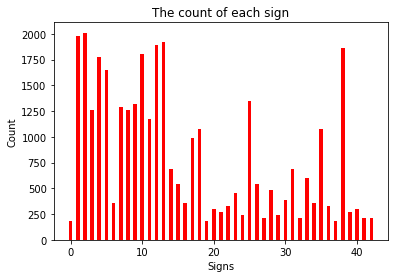

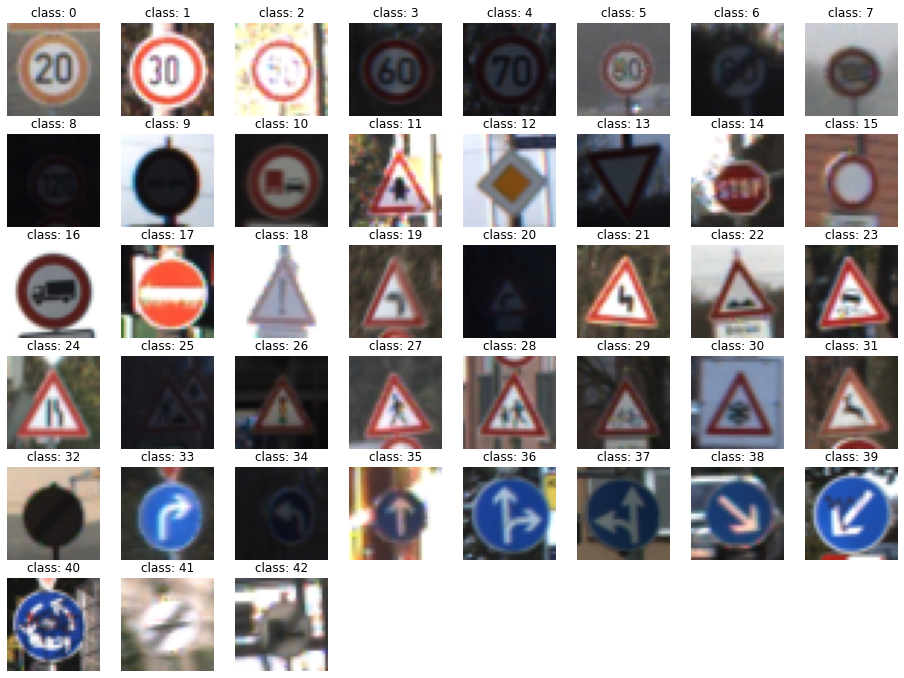

In [ ]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(y_train), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(X_train[i])

----

# Design and Test a Baseline Model Architecture

## Custom Dataset & DataLoader

In [ ]:
class PickledDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, mode='rb') as f:
            data = pickle.load(f)
            self.features = data['features']
            self.labels = data['labels']
            self.count = len(self.labels)
            self.transform = transform
        
    def __getitem__(self, index):
        feature = self.features[index]
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, self.labels[index])

    def __len__(self):
        return self.count

In [ ]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

## Baseline Model

In [ ]:
class BaselineNet(nn.Module):
    def __init__(self, gray=False):
        super(BaselineNet, self).__init__()
        input_chan = 1 if gray else 3
        self.conv1 = nn.Conv2d(input_chan, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training

In [ ]:
torch.manual_seed(1)

In [ ]:
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

train_loader = WrappedDataLoader(train_loader, to_device)
valid_loader = WrappedDataLoader(valid_loader, to_device)
test_loader = WrappedDataLoader(test_loader, to_device)

In [ ]:
model = BaselineNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
n_epochs = 20

In [ ]:
BaselineNet()

BaselineNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=43, bias=True)
)

In [ ]:
def loss_batch(model, loss_func, x, y, opt=None):
    loss = loss_func(model(x), y)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x)

In [ ]:
def valid_batch(model, loss_func, x, y,disp):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)
    if disp==True:
      plt.figure(figsize=(16, 16))
      c=0
      for i in range(len(correct)):
        c+=1
        if c==10:
          break
        if correct[i]==False:
              plt.subplot(8, 8, c+1)
              plt.axis('off')
              plt.title('Original: {} Pred {}'.format(y[i],pred[i]))
              #plt.imshow(clahe(X_train[i]).squeeze(), cmap='gray')
              plt.imshow(x[i][0].to('cpu'),cmap='gray')
      plt.show()
    #print(len(pred))
    
    return loss.item(), torch.sum(correct).item(), len(x)

In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl,disp):
    train_loss_list=[]
    val_loss_list=[]
    val_acc_list=[]
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        train_loss_list.append(train_loss)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y,disp) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            val_loss_list.append(valid_loss)
            val_acc_list.append(valid_accuracy)
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accuracy: {valid_accuracy:.3f}%")
    return  train_loss_list,val_loss_list,val_acc_list      

In [ ]:
def evaluate(model, loss_func, dl,disp):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y,disp) for x, y in dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_accuracy = np.sum(corrects) / np.sum(nums) * 100
        print(f"Test loss: {test_loss:.6f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")

In [ ]:
tr_loss_list,vl_loss_list,vl_accuracy_list=fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader,False)
evaluate(model, criterion, test_loader,False)

[Epoch 1/20] Train loss: 3.675913	Validation loss: 3.592869	 Validation accuracy: 5.442%
[Epoch 2/20] Train loss: 3.483910	Validation loss: 3.568367	 Validation accuracy: 5.533%
[Epoch 3/20] Train loss: 3.455319	Validation loss: 3.537347	 Validation accuracy: 7.800%
[Epoch 4/20] Train loss: 3.326124	Validation loss: 3.277129	 Validation accuracy: 22.063%
[Epoch 5/20] Train loss: 2.651625	Validation loss: 2.303394	 Validation accuracy: 38.413%
[Epoch 6/20] Train loss: 1.666444	Validation loss: 1.556393	 Validation accuracy: 55.420%
[Epoch 7/20] Train loss: 1.115128	Validation loss: 1.123955	 Validation accuracy: 68.163%
[Epoch 8/20] Train loss: 0.813570	Validation loss: 1.065140	 Validation accuracy: 71.383%
[Epoch 9/20] Train loss: 0.644458	Validation loss: 0.790564	 Validation accuracy: 78.186%
[Epoch 10/20] Train loss: 0.534927	Validation loss: 0.822711	 Validation accuracy: 77.506%
[Epoch 11/20] Train loss: 0.453817	Validation loss: 0.754073	 Validation accuracy: 80.612%
[Epoch 12/2

## Plots for Baseline

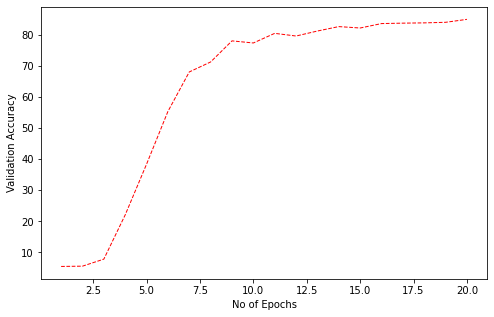

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.asarray([i for i in range(1,21)])

plt.figure(num = 3, figsize=(8, 5))
plt.plot(x, np.asarray(vl_accuracy_list), 
         color='red',   
         linewidth=1.0,  
         linestyle='--' 
        )
plt.xlabel('No of Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

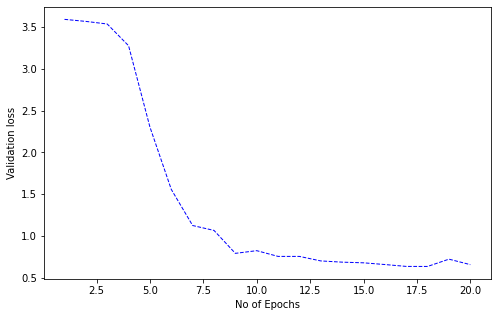

In [ ]:
x = np.asarray([i for i in range(1,21)])

plt.figure(num = 3, figsize=(8, 5))
plt.plot(x, np.asarray(vl_loss_list), 
         color='blue',   
         linewidth=1.0,  
         linestyle='--' 
        )
plt.xlabel('No of Epochs')
plt.ylabel('Validation loss')
plt.show()

---
# Experiment and find tuning

## Data preprocessing

In [ ]:
class CLAHE_GRAY:
    def __init__(self, clipLimit=2.5, tileGridSize=(4, 4)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize

    def __call__(self, im):
        img_y = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)[:,:,0]
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        img_y = clahe.apply(img_y)
        img_output = img_y.reshape(img_y.shape + (1,))
        return img_output

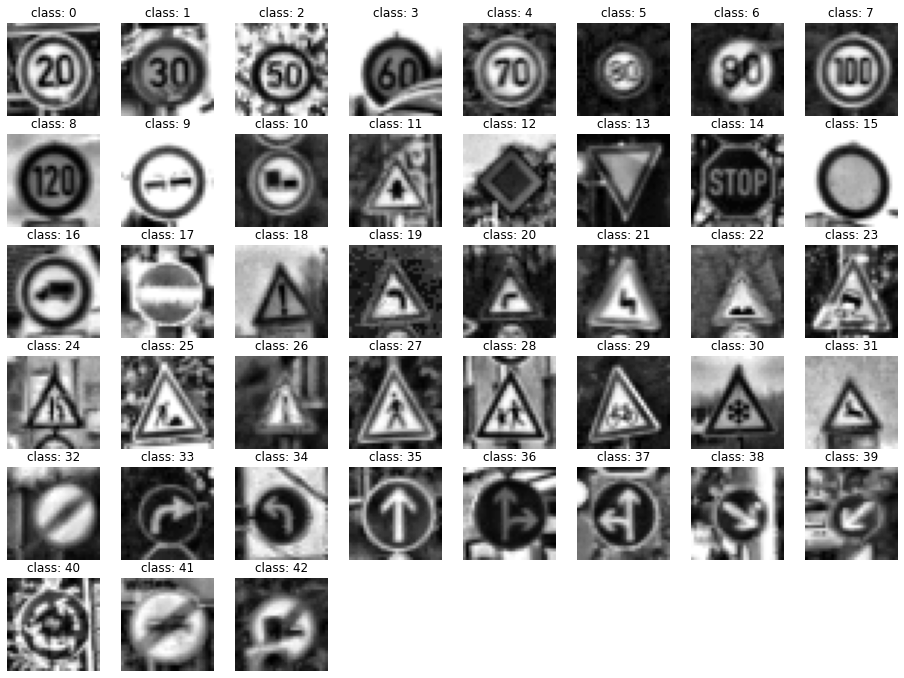

In [ ]:
clahe = CLAHE_GRAY()
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(clahe(X_train[i]).squeeze(), cmap='gray')

In [ ]:
data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToTensor()
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

In [ ]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
tr_loss_list,vl_loss_list,vl_accuracy_list=fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader,disp=False)
evaluate(model, criterion, test_loader,disp=False)

[Epoch 1/20] Train loss: 3.662081	Validation loss: 3.562241	 Validation accuracy: 5.510%
[Epoch 2/20] Train loss: 3.475382	Validation loss: 3.547858	 Validation accuracy: 5.556%
[Epoch 3/20] Train loss: 3.458555	Validation loss: 3.527713	 Validation accuracy: 11.429%
[Epoch 4/20] Train loss: 3.387836	Validation loss: 3.366235	 Validation accuracy: 16.712%
[Epoch 5/20] Train loss: 2.769919	Validation loss: 2.239037	 Validation accuracy: 39.297%
[Epoch 6/20] Train loss: 1.575552	Validation loss: 1.491839	 Validation accuracy: 52.063%
[Epoch 7/20] Train loss: 1.014005	Validation loss: 1.028104	 Validation accuracy: 68.753%
[Epoch 8/20] Train loss: 0.769446	Validation loss: 0.861431	 Validation accuracy: 74.104%
[Epoch 9/20] Train loss: 0.621605	Validation loss: 0.653266	 Validation accuracy: 81.224%
[Epoch 10/20] Train loss: 0.519447	Validation loss: 0.622170	 Validation accuracy: 83.129%
[Epoch 11/20] Train loss: 0.451696	Validation loss: 0.591315	 Validation accuracy: 82.290%
[Epoch 12/

## **BaseLine Model Plots(After CLAHE and Gray Scale)**

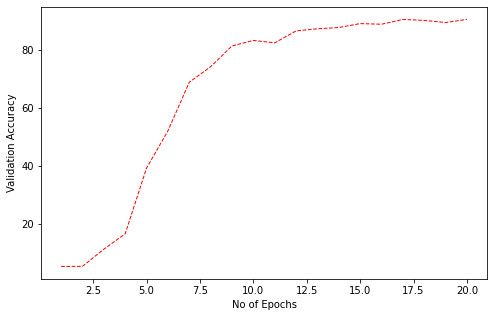

In [ ]:
plt.figure(num = 3, figsize=(8, 5))
plt.plot(x, np.asarray(vl_accuracy_list), 
         color='red',   
         linewidth=1.0,  
         linestyle='--' 
        )
plt.xlabel('No of Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

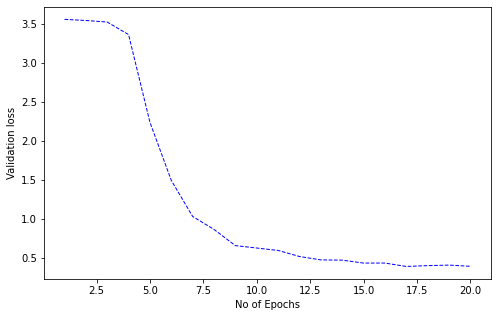

In [ ]:
plt.figure(num = 3, figsize=(8, 5))
plt.plot(x, np.asarray(vl_loss_list), 
         color='blue',   
         linewidth=1.0,  
         linestyle='--' 
        )
plt.xlabel('No of Epochs')
plt.ylabel('Validation loss')
plt.show()

## Save preprocessed images

In [ ]:
def preprocess(path):
    if not os.path.exists(f"{path}/train_gray.p"):
        for dataset in ['train', 'valid', 'test']:
            with open(f"{path}/{dataset}.p", mode='rb') as f:
                data = pickle.load(f)
                X = data['features']
                y = data['labels']

            clahe = CLAHE_GRAY()
            for i in range(len(X)):
                X[i] = clahe(X[i])

            X = X[:, :, :, 0]
            with open(f"{path}/{dataset}_gray.p", "wb") as f:
                pickle.dump({"features": X.reshape(
                    X.shape + (1,)), "labels": y}, f)

In [ ]:
preprocess('data')
training_file = 'data/train_gray.p'
validation_file = "data/valid_gray.p"
testing_file = "data/test_gray.p"

In [ ]:
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

## Handling imbalanced dataset

### Flipping

In [ ]:
def extend_dataset(dataset):
    X = dataset.features
    y = dataset.labels
    num_classes = 43
    
    X_extended = np.empty([0] + list(dataset.features.shape)[1:], dtype=dataset.features.dtype)
    y_extended = np.empty([0], dtype = dataset.labels.dtype)
    
    horizontally_flippable = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
    vertically_flippable = [1, 5, 12, 15, 17]
    both_flippable = [32, 40]
    cross_flippable = np.array([
        [19, 20],
        [33, 34],
        [36, 37],
        [38, 39],
        [20, 19],
        [34, 33],
        [37, 36],
        [39, 38]
    ])
    
    for c in range(num_classes):
        X_extended = np.append(X_extended, X[y==c], axis=0)  
        
        if c in horizontally_flippable:
            X_extended = np.append(X_extended, X[y==c][:,:,::-1,:], axis=0)
        if c in vertically_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,:,:], axis=0)
        if c in cross_flippable[:,0]:
            flip_c = cross_flippable[cross_flippable[:,0]==c][0][1]
            X_extended = np.append(X_extended, X[y==flip_c][:,:,::-1,:], axis=0)
        if c in both_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,::-1,:], axis=0)
        
        y_extended = np.append(y_extended, np.full(X_extended.shape[0]-y_extended.shape[0], c, dtype=y_extended.dtype))
    
    dataset.features = X_extended
    dataset.labels = y_extended
    dataset.count = len(y_extended)
    
    return dataset

In [ ]:
train_dataset = extend_dataset(train_dataset)
train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)

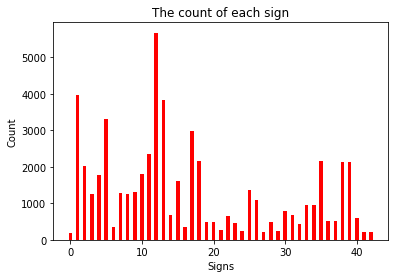

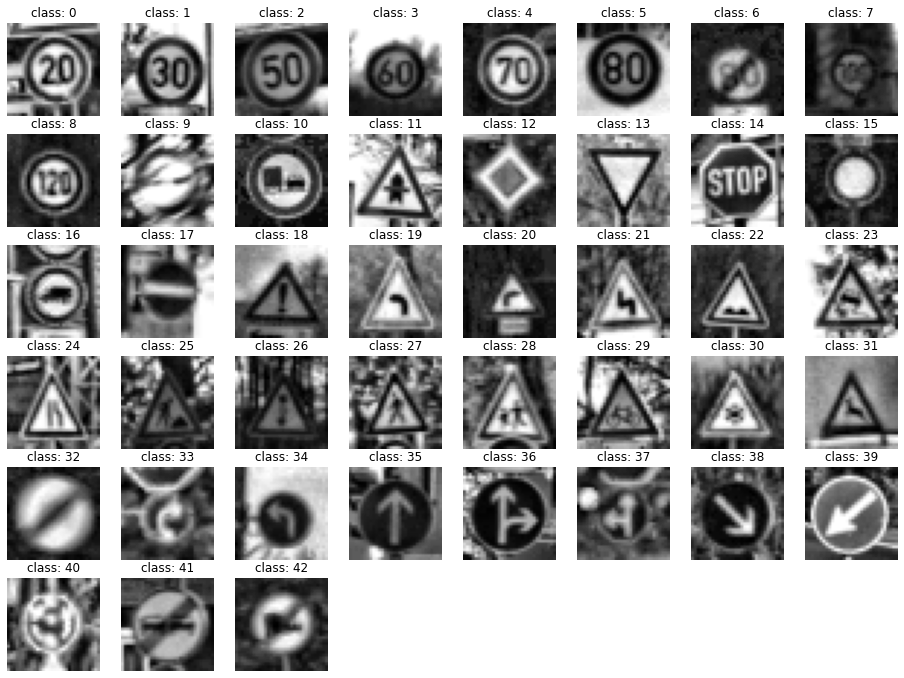

In [ ]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(train_dataset.labels), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(train_dataset.labels == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(train_dataset.features[i].squeeze(), cmap='gray')

In [ ]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader,disp=False)
evaluate(model, criterion, test_loader,disp=False)

[Epoch 1/20] Train loss: 3.622044	Validation loss: 3.640928	 Validation accuracy: 4.762%
[Epoch 2/20] Train loss: 3.395629	Validation loss: 3.616166	 Validation accuracy: 4.762%
[Epoch 3/20] Train loss: 3.262825	Validation loss: 3.194307	 Validation accuracy: 16.077%
[Epoch 4/20] Train loss: 1.954778	Validation loss: 1.560500	 Validation accuracy: 55.034%
[Epoch 5/20] Train loss: 0.994874	Validation loss: 0.996054	 Validation accuracy: 71.791%
[Epoch 6/20] Train loss: 0.679173	Validation loss: 0.790141	 Validation accuracy: 76.735%
[Epoch 7/20] Train loss: 0.504552	Validation loss: 0.653090	 Validation accuracy: 81.769%
[Epoch 8/20] Train loss: 0.399517	Validation loss: 0.548598	 Validation accuracy: 84.626%
[Epoch 9/20] Train loss: 0.323858	Validation loss: 0.556448	 Validation accuracy: 84.535%
[Epoch 10/20] Train loss: 0.270594	Validation loss: 0.507001	 Validation accuracy: 86.032%
[Epoch 11/20] Train loss: 0.230014	Validation loss: 0.438157	 Validation accuracy: 88.095%
[Epoch 12/

### Augmentation

In [ ]:
train_dataset = extend_dataset(PickledDataset(training_file))

class_sample_count = np.bincount(train_dataset.labels)
weights = 1 / np.array([class_sample_count[y] for y in train_dataset.labels])
samp = sampler.WeightedRandomSampler(weights, 43 * 20000)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=samp), to_device)

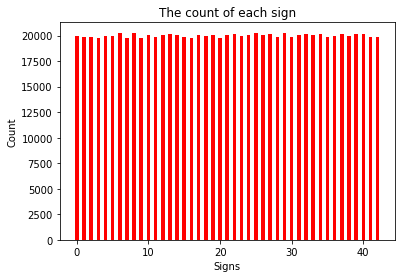

In [ ]:
balanced_y_train = torch.LongTensor([]).to(device)

with torch.no_grad():
    for _, y in train_loader:
        balanced_y_train = torch.cat((balanced_y_train, y))

fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(balanced_y_train.cpu().numpy()), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

In [ ]:
train_data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomApply([
        transforms.RandomRotation(20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, translate=(0.2, 0.2), resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, shear=20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, scale=(0.8, 1.2), resample=PIL.Image.BICUBIC)
    ]),
    transforms.ToTensor()
])
test_data_transforms = transforms.ToTensor()

train_dataset = extend_dataset(PickledDataset(training_file, transform=train_data_transforms))
valid_dataset = PickledDataset(validation_file, transform=test_data_transforms)
test_dataset = PickledDataset(testing_file, transform=test_data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=samp), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1362: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


In [ ]:
def convert_image_np(img):
    img = img.numpy().transpose((1, 2, 0)).squeeze()
    return img

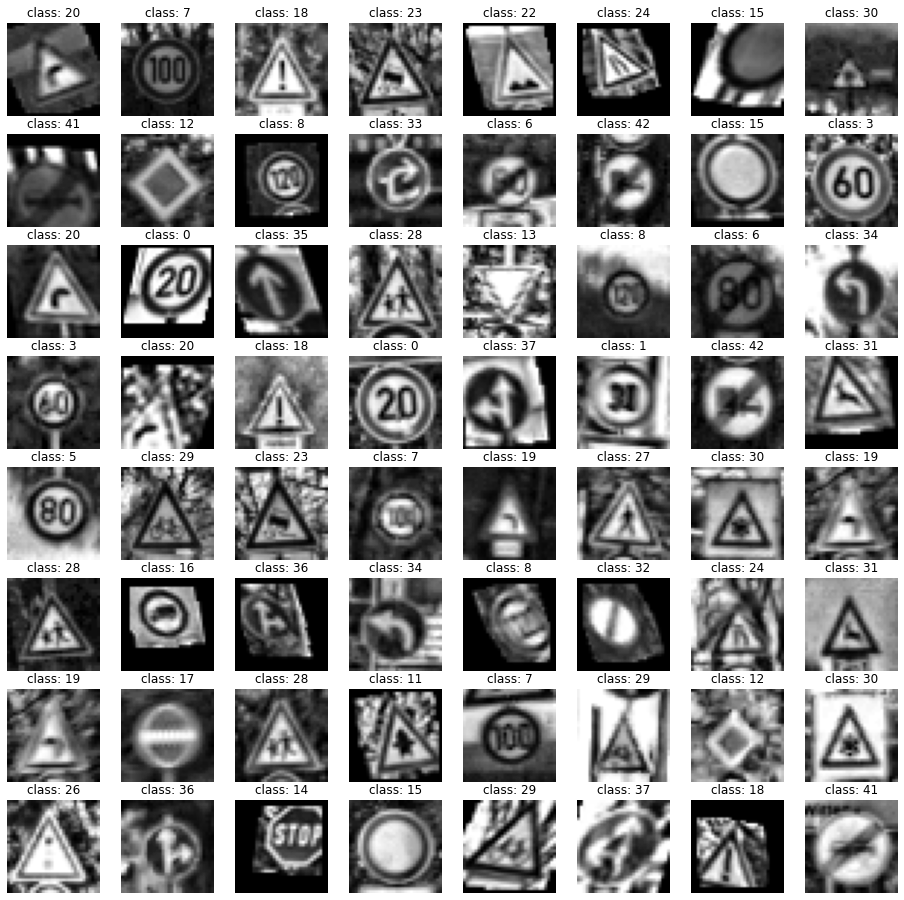

In [ ]:
with torch.no_grad():
    x, y = next(iter(train_loader))
    plt.figure(figsize=(16, 16))
    for i in range(len(y)):
        plt.subplot(8, 8, i+1)
        plt.axis('off')
        plt.title('class: {}'.format(y[i]))
        plt.imshow(convert_image_np(x[i].cpu()), cmap='gray')

In [ ]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
tr_loss_list,vl_loss_list,vl_accuracy_list=fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader,disp=False)
evaluate(model, criterion, test_loader,disp=False)

[Epoch 1/20] Train loss: 2.663591	Validation loss: 0.616484	 Validation accuracy: 81.565%
[Epoch 2/20] Train loss: 0.804350	Validation loss: 0.342722	 Validation accuracy: 91.043%


## Model

In [ ]:
class TrafficSignNet(nn.Module):
    def __init__(self):
        super(TrafficSignNet, self).__init__()
        # Constraints for layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride = 1, padding=2)
        self.batch1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2) #default stride is equivalent to the kernel_size
        # Constraints for layer 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride = 1, padding=2)
        self.batch2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        # Defining the Linear layer
        self.fc1 = nn.Linear(2048,1024)
        self.dropout = nn.Dropout(p=0.5)
        # Defining the Linear layer
        self.fc2 = nn.Linear(1024,256)
        self.dropout1 = nn.Dropout(p=0.5)
        # Defining the Linear layer
        self.fc3 = nn.Linear(256,43)

    # defining the network flow
    def forward(self, x):
          # Conv 1
          out = self.conv1(x)
          out = self.batch1(out)
          out = self.relu1(out)
          # Max Pool 1
          out = self.pool1(out)
          # Conv 2
          out = self.conv2(out)
          out = self.batch2(out)
          out = self.relu2(out)
          # Max Pool 2
          out = self.pool2(out)
          out = out.view(out.size(0),-1)
          # Linear Layer
          out = self.fc1(out)
          out=self.dropout(out)
          # Linear layer
          out = self.fc2(out)
          out=self.dropout1(out)
          # Linear layer
          out = self.fc3(out)
          return out

In [ ]:
TrafficSignNet()

TrafficSignNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=43, bias=True)
)

In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, patience=10):
    wait = 0
    valid_loss_min = np.Inf
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y,disp=False) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")
            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), 'model.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return

In [ ]:
n_epochs = 20
cnn_model1= TrafficSignNet().to(device)
optimizer = optim.Adam(cnn_model1.parameters(), lr=0.001)
fit(n_epochs, cnn_model1, criterion, optimizer, train_loader, valid_loader)

[Epoch 1/20] Train loss: 0.417258	Validation loss: 0.157938	 Validation accruacy: 96.599%
Validation loss decreased (inf --> 0.157938). Saving model...
[Epoch 2/20] Train loss: 0.172669	Validation loss: 0.098514	 Validation accruacy: 97.642%
Validation loss decreased (0.157938 --> 0.098514). Saving model...
[Epoch 3/20] Train loss: 0.148791	Validation loss: 0.107337	 Validation accruacy: 97.234%
[Epoch 4/20] Train loss: 0.139267	Validation loss: 0.083028	 Validation accruacy: 97.755%
Validation loss decreased (0.098514 --> 0.083028). Saving model...
[Epoch 5/20] Train loss: 0.130420	Validation loss: 0.154050	 Validation accruacy: 97.664%
[Epoch 6/20] Train loss: 0.125920	Validation loss: 0.214661	 Validation accruacy: 96.417%
[Epoch 7/20] Train loss: 0.120970	Validation loss: 0.155460	 Validation accruacy: 97.460%
[Epoch 8/20] Train loss: 0.117071	Validation loss: 0.179531	 Validation accruacy: 97.528%
[Epoch 9/20] Train loss: 0.114151	Validation loss: 0.157908	 Validation accruacy: 97

In [ ]:
torch.save(cnn_model1.state_dict(), 'CNN_model1.pt')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

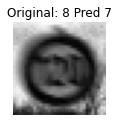

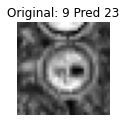

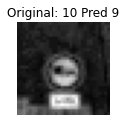

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

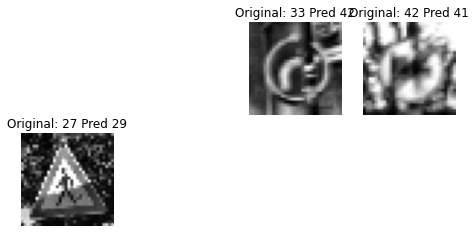

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

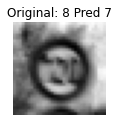

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

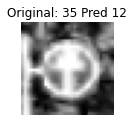

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

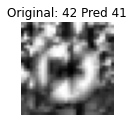

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

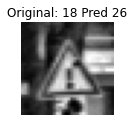

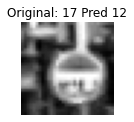

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

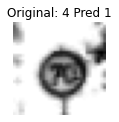

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

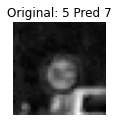

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

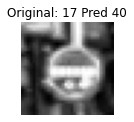

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

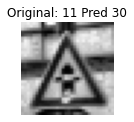

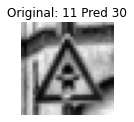

<Figure size 1152x1152 with 0 Axes>

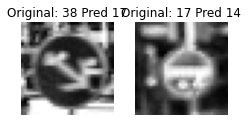

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

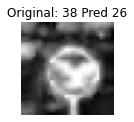

<Figure size 1152x1152 with 0 Axes>

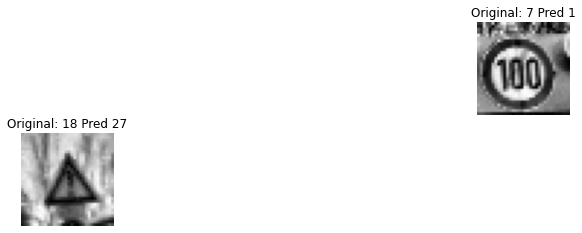

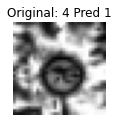

<Figure size 1152x1152 with 0 Axes>

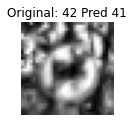

<Figure size 1152x1152 with 0 Axes>

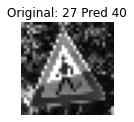

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

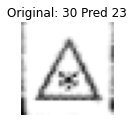

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

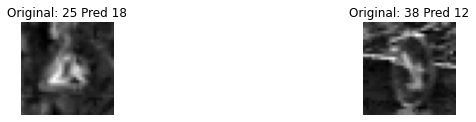

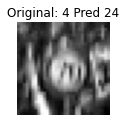

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

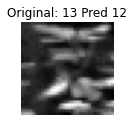

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

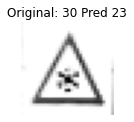

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

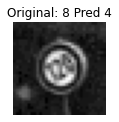

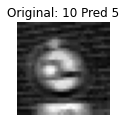

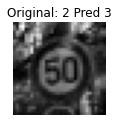

<Figure size 1152x1152 with 0 Axes>

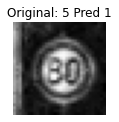

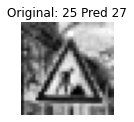

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

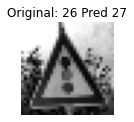

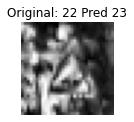

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

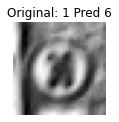

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

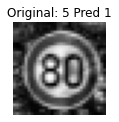

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

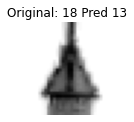

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

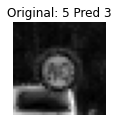

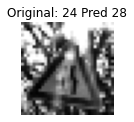

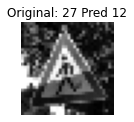

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

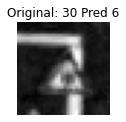

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

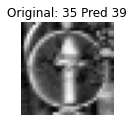

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

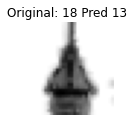

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

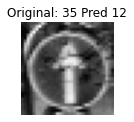

<Figure size 1152x1152 with 0 Axes>

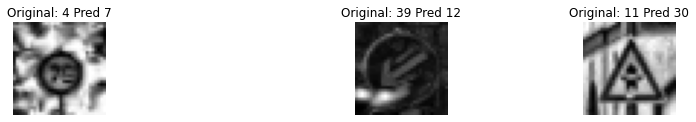

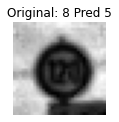

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

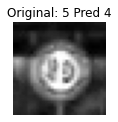

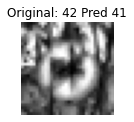

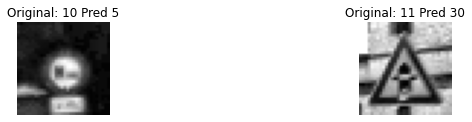

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

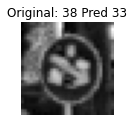

<Figure size 1152x1152 with 0 Axes>

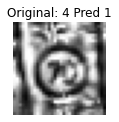

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

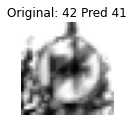

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

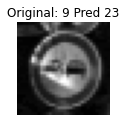

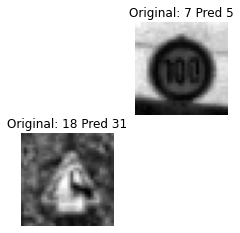

Test loss: 0.240150	Test accruacy: 96.239%


In [ ]:
cnn_model1= TrafficSignNet().to(device)
check_point = torch.load('CNN_model1.pt', map_location=device)
criterion = nn.CrossEntropyLoss()
cnn_model1.load_state_dict(check_point)
evaluate(cnn_model1, criterion, test_loader,disp=True)


In [ ]:
evaluate(cnn_model1, criterion, test_loader,disp=False)

Test loss: 0.240150	Test accruacy: 96.239%


**Confusion Matrix**

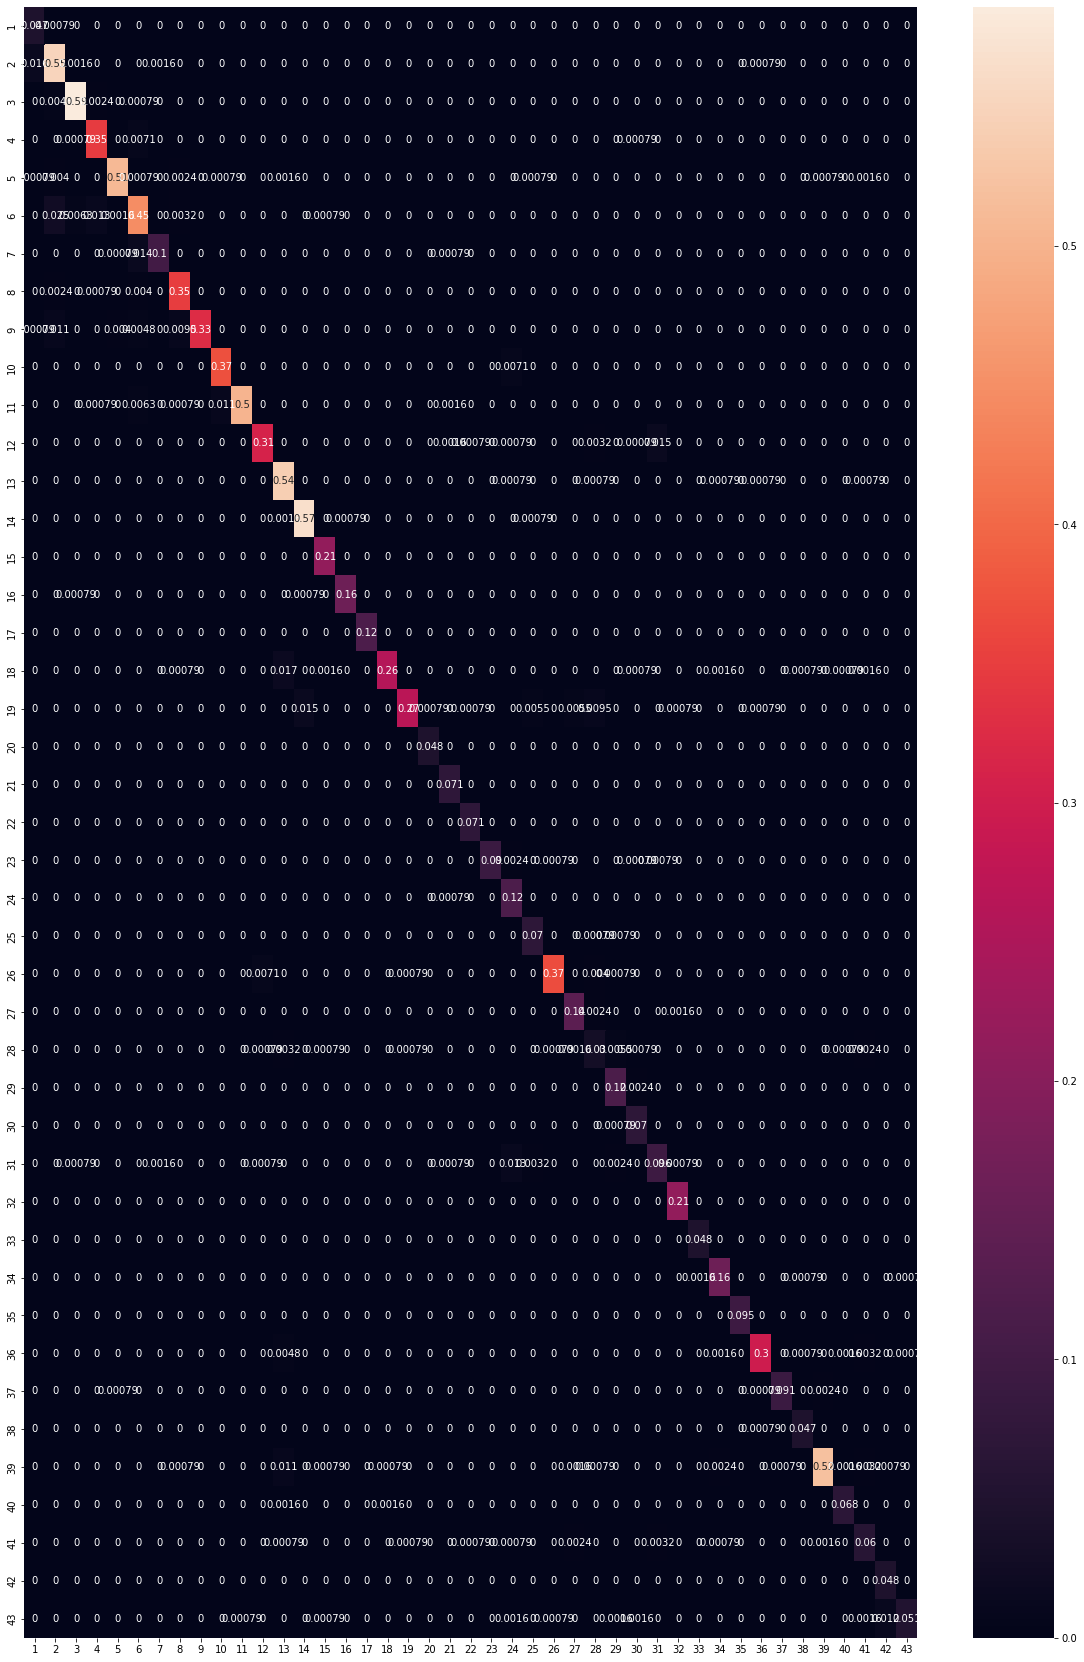

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = cnn_model1(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39','40','41','42','43')
# Build confusion matrix
cf_matrix = confusion_matrix(y_true[:], y_pred[:])
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20,30))
sn.heatmap(df_cm, annot=True)

## Future Work
### Testing On USA Traffic Images
### Improving the accuracy of the model using Spatial Transformer networks
